In [1]:
# packages to install
# install.packages("performanceEstimation")
# install.packages("fpp3")
# install.packages("knitr")
# install.packages("vars")

library(dplyr)
library(lubridate)
library(ggplot2)
library(ggplot2)
library(performanceEstimation)
library(PerformanceAnalytics)
library(Hmisc)
library(corrplot)
library(forecast)
library(knitr)
library(vars)


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union



Caricamento pacchetto: 'lubridate'


I seguenti oggetti sono mascherati da 'package:base':

    date, intersect, setdiff, union


Warning message:
"il pacchetto 'performanceEstimation' è stato creato con R versione 4.2.3"
Warning message:
"il pacchetto 'PerformanceAnalytics' è stato creato con R versione 4.2.3"
Caricamento del pacchetto richiesto: xts

Warning message:
"il pacchetto 'xts' è stato creato con R versione 4.2.3"
Caricamento del pacchetto richiesto: zoo

Warning message:
"il pacchetto 'zoo' è stato creato con R versione 4.2.3"

Caricamento pacchetto: 'zoo'


I seguenti oggetti sono mascherati da 'package:base':

    as.Date, as.Date.numeric



################################### WARNING ###################################
# We noticed you have dplyr installed. The dplyr l

# Assumptions

This project is dedicated to the comprehensive analysis of the collective behavior of a network of electricity consumers by making inference on the aggregated data representing the average user. 

While the Python component of the project focuses on predicting the behavior of individual consumers, the goal for the following notebook is to unravel the impact of heterogeneous variables on the consumption profile of the network.
To do so we will operate under the following assumptions:

1) **Representativeness of Data**: We presume that, with the exception of the initial months when clients were joining the network, the data accurately reflects consumption patterns across the entire network;
2) **Client Consumption Scope**: It is assumed that clients exhibit no energy consumption beyond what is documented in the provided dataset;
3) **Missing Values Attribution**: Missing values are interpreted as a consequence of communication issues between smart meters and the operations center, rather than indicating zero consumption by the client.
4) **Downward Trend Causes**: The downward trend identified through yearly seasonal decomposition is attributed to variations in consumer behavior, such as the adoption of greener technologies (e.g., solar panels, LED light bulbs, improved water heaters), rather than being solely influenced by weather conditions.;

# STEP 1: IMPORT AND ORGANIZE DATA FROM FS
The dataset was distributed across various CSV files. However, for the purposes of this analysis, only four files held pertinent information for inclusion in the case study:

* `daily_dataset.csv` Encompassing the daily consumption profiles of users within the distribution network;
* `information_households.csv` Containing identifiers for households and their tariff plan types, either Std (Standard) or ToU (Time of Use);
* `uk_bank_holiday.csv` Listing all dates designated as UK bank holidays;
* `weather_daily_darksky.csv` Detailing the daily weather conditions in London throughout the analysis period.

Once the import process was completed it was a matter of merging the tables of the dataset using the primary and foreign keys of one another.s


In [2]:
daily_dataset <- ".\\archive\\daily_dataset.csv"
informations_households <- ".\\archive\\informations_households.csv"
uk_bank_holidays <- ".\\archive\\uk_bank_holidays.csv"
weather_daily_darksky <- ".\\archive\\weather_daily_darksky.csv"

# Import the CSV files
daily_dataset <- read.csv(daily_dataset)
informations_households <- read.csv(informations_households)
uk_bank_holidays <- read.csv(uk_bank_holidays)
weather_daily_darksky <- read.csv(weather_daily_darksky)

# Augment daily_dataset: flag UK holiday days, add DOW and DOY columns,
daily_dataset.augmented <- daily_dataset %>%
  mutate(
      isUkHoliday = as.numeric(day %in% uk_bank_holidays$Bank.holidays),
      day = as.Date(day, format = "%Y-%m-%d"),
      dayOfWeek = wday(day, week_start=1),
      dayOfYear = as.numeric(strftime(day, format = "%j")),
      consumption = energy_sum
  )

# Augment weather_daily_darksky: add sunlight hours column, correct format of day column and remove duplicates
weather_daily_darksky <- weather_daily_darksky %>%
    mutate(
        sunlightHours = difftime(sunsetTime, sunriseTime, units = "hours"),
        weather_condition = icon
    )
weather_daily_darksky$day <- as.Date(weather_daily_darksky$time)
weather_daily_darksky <- weather_daily_darksky[!duplicated(weather_daily_darksky$day), ]

# Merge datasets and select only the useful columns
daily_dataset.merged <- daily_dataset.augmented %>%
    inner_join(informations_households, by = "LCLid") %>%
    inner_join(weather_daily_darksky, by = c("day" = "day")) %>%
    dplyr::select(
        LCLid,
        day,
        consumption,
        isUkHoliday,
        dayOfWeek,
        dayOfYear,
        stdorToU,
        weather_condition,
        cloudCover,
        windBearing,
        windSpeed,
        pressure,
        visibility,
        humidity,
        precipType,
        uvIndex,
        sunlightHours,
        temperatureMin,
        temperatureMax
    )

# STEP 2: DATA EXPLORATION, DATA CLEANING AND DATA TRANSFORMATION

## 2.1: Data frequency analysis
In this phase, our focus shifts to the exploration, cleaning, and transformation of the dataset. This critical process is undertaken with the explicit goal of ensuring the data's reliability and enhancing its utility for subsequent analyses.

To gain insight into the temporal distribution of data points, a frequency table is generated across different days in the `daily_dataset`. The resulting frequency data is visualized using a line plot. 

Notably, a discernible pattern emerges, revealing a scarcity of available data in the initial months of the program. To address this observation, a threshold is introduced representing 75% of the maximum frequency. This threshold serves as a filter, effectively excluding days with lower data frequency from the dataset.

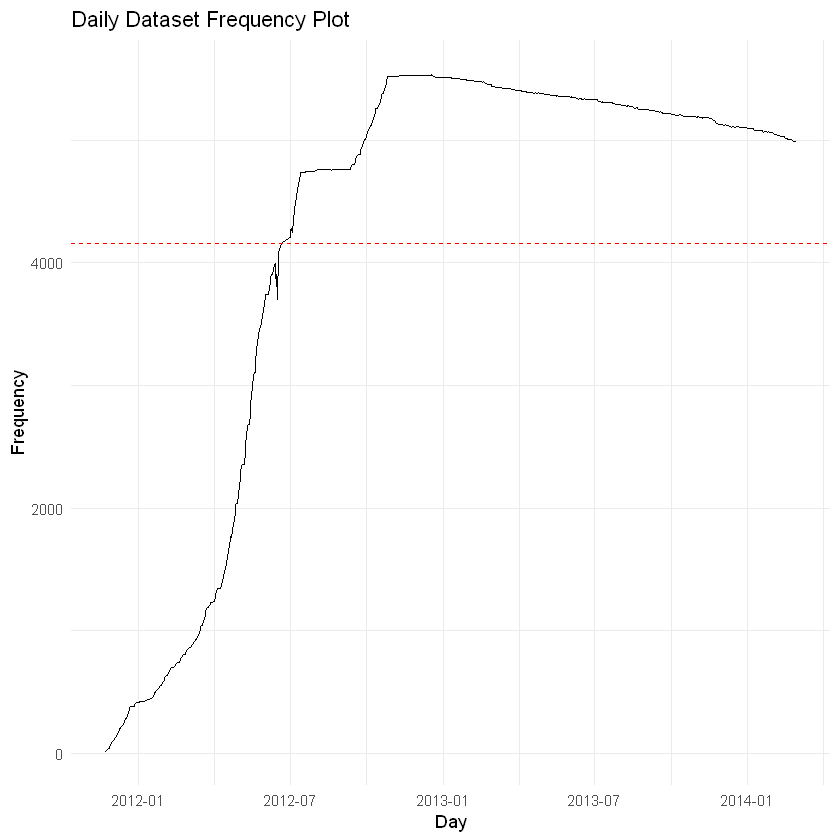

In [3]:
freq_table <- table(daily_dataset$day)
freq_data <- as.data.frame(table(daily_dataset$day))
freq_data$day <- as.Date(names(freq_table))

threshold <- 0.75 * max(freq_data$Freq)

ggplot(freq_data, aes(x = day, y = Freq)) +
  geom_line() +
  geom_hline(yintercept = threshold, linetype = "dashed", color = "red") +
  labs(title = "Daily Dataset Frequency Plot", x = "Day", y = "Frequency") +
  theme_minimal()

In [4]:
# filtering values whose frequency is lower than threshold
daily_dataset.filtered <- daily_dataset.merged[daily_dataset.merged$day %in% freq_data$day[freq_data$Freq >= threshold], ]

unfiltered_data_points.mln <- round(nrow(daily_dataset.merged) / 1000000, 1)
filtered_data_points.mln <- round(nrow(daily_dataset.filtered) / 1000000, 1)

cat("Unfiltered Data Points (in millions):", unfiltered_data_points.mln, "\n")
cat("Filtered Data Points (in millions):", filtered_data_points.mln, "\n")

Unfiltered Data Points (in millions): 3.5 
Filtered Data Points (in millions): 3.2 


The impact of this filtration is quantified with unfiltered data points totaling 3.5 million and filtered data points and representative of higher-frequency occurrences, amounting to 3.2 million. 

## 2.2: missing values imputation
Continuing our data refinement journey, the next step involves an examination of missing values within the filtered dataset which sets the stage for targeted imputation strategies and ensures the integrity of our data for subsequent analyses.

In [5]:
# identifying missing values

summary(daily_dataset.filtered)

consumption_missing_values <- sum(is.na(daily_dataset.filtered$consumption))
cloudCover_missing_values <- sum(is.na(daily_dataset.filtered$cloudCover))
uvIndex_missing_values <- sum(is.na(daily_dataset.filtered$uvIndex))

cat("Consumption Missing Values:", consumption_missing_values, "\n")
cat("Cloud Cover Missing Values:", cloudCover_missing_values, "\n")
cat("UV Index Missing Values:", uvIndex_missing_values, "\n")

cc_uv_missing_values.date <- unique(daily_dataset.filtered[is.na(daily_dataset.filtered$cloudCover) & is.na(daily_dataset.filtered$uvIndex), ]$day) # nolint: line_length_linter.
cat("Unique Dates with Both Cloud Cover and UV Index Missing Values:", format(cc_uv_missing_values.date, format = "%d %B %Y"), "\n")

consumption_missing_values.dates.num <- length(unique(daily_dataset.filtered[is.na(daily_dataset.filtered$consumption), ]$day)) # nolint: line_length_linter.
cat("Number of Unique Dates with Consumption Missing Values:", consumption_missing_values.dates.num, "\n")

values_cc_uv_missing_values.dates <- sum(daily_dataset.filtered$day == as.Date(cc_uv_missing_values.date))
cat("Number of values for the [", format(cc_uv_missing_values.date, format = "%d %B %Y"), "]: ", values_cc_uv_missing_values.dates, "\n")

    LCLid                day              consumption       isUkHoliday     
 Length:3202962     Min.   :2012-06-22   Min.   :  0.000   Min.   :0.00000  
 Class :character   1st Qu.:2012-12-01   1st Qu.:  4.682   1st Qu.:0.00000  
 Mode  :character   Median :2013-04-26   Median :  7.832   Median :0.00000  
                    Mean   :2013-04-27   Mean   : 10.146   Mean   :0.02267  
                    3rd Qu.:2013-09-24   3rd Qu.: 12.588   3rd Qu.:0.00000  
                    Max.   :2014-02-28   Max.   :332.556   Max.   :1.00000  
                                         NA's   :30                         
   dayOfWeek       dayOfYear       stdorToU         weather_condition 
 Min.   :1.000   Min.   :  1.0   Length:3202962     Length:3202962    
 1st Qu.:2.000   1st Qu.: 92.0   Class :character   Class :character  
 Median :4.000   Median :211.0   Mode  :character   Mode  :character  
 Mean   :3.991   Mean   :194.8                                        
 3rd Qu.:6.000   3rd Qu.:290.

Consumption Missing Values: 30 
Cloud Cover Missing Values: 5099 
UV Index Missing Values: 5099 
Unique Dates with Both Cloud Cover and UV Index Missing Values: 01 gennaio 2014 
Number of Unique Dates with Consumption Missing Values: 9 
Number of values for the [ 01 gennaio 2014 ]:  5099 


In our examination of the dataset, a small number of null values were identified across three distinct columns:

* \[9\] entries in the `Consumption` column
* \[5099\] entries in both the `Cloud Coverage` index and `Ultraviolet Index` columns

The null values in the Consumption column are scattered across \[9\] different days. Conversely, the missing values in the Cloud Coverage Index and Ultraviolet Index columns represent the entire dataset for the 1st of January 2014. This absence of values is attributed to the original data source, "weather_daily_darksky," where each row corresponds to the weather conditions for a single day.

Given the nature of this dataset, employing basic data imputation techniques might lead to misleading results, particularly for variables strongly influenced by weather conditions. A change in weather conditions can significantly impact these variables. Therefore, a more sophisticated approach is suggested.

Considering the complexity of our data, the K-nearest neighbors (KNN) data imputation function emerges as a promising solution. This method takes into account the proximity of data points in a multidimensional space, making it well-suited for scenarios where variables are closely tied to contextual factors such as weather conditions.

In [6]:
# Cloud Cover and UV Index Imputation of Missing Values

# Impute missing values for UV Index and Cloud Cover in the 'weather_daily_darksky' table
weather_daily_darksky$sunlightHours_numeric <- as.numeric(weather_daily_darksky$sunlightHours)

# Define features for imputation in 'weather_daily_darksky'
features <- c("temperatureMax", "temperatureMin", "windBearing", "dewPoint", "windSpeed", "pressure", "visibility", "humidity", "sunlightHours_numeric", "x")

# Impute values
weather_daily_darksky$x <- as.numeric(weather_daily_darksky$uvIndex)
weather_daily_darksky$uvIndex <- knnImp(weather_daily_darksky[, features], k = 10)$x
weather_daily_darksky$x <- as.numeric(weather_daily_darksky$cloudCover)
weather_daily_darksky$cloudCover <- knnImp(weather_daily_darksky[, features], k = 10)$x

# Re-Merge and select relevant columns in 'daily_dataset.filtered'
daily_dataset.filtered <- daily_dataset.filtered[, !(names(daily_dataset.filtered) %in% setdiff(colnames(weather_daily_darksky), "day"))]
daily_dataset.filtered <- daily_dataset.filtered %>%
  inner_join(weather_daily_darksky, by = c("day" = "day")) %>%
  dplyr::select(
    LCLid,
    day,
    consumption,
    isUkHoliday,
    dayOfWeek,
    dayOfYear,
    stdorToU,
    weather_condition,
    cloudCover,
    windBearing,
    windSpeed,
    pressure,
    visibility,
    humidity,
    precipType,
    uvIndex,
    sunlightHours,
    temperatureMin,
    temperatureMax,
    sunlightHours_numeric
  )

daily_dataset.filtered$sunlightHours <- as.numeric(daily_dataset.filtered$sunlightHours)

# Define the features for imputation
features <- c("dayOfYear", "dayOfWeek", "temperatureMax", "temperatureMin", "windBearing", "windSpeed", "pressure", "visibility", "humidity", "sunlightHours", "x", "uvIndex", "cloudCover")

# imputate on a per-user basis
LCLid.list <- unique(daily_dataset.filtered[is.na(daily_dataset.filtered$consumption), ]$LCLid)

# Iterate through users for consumption imputation
daily_dataset.filtered$x <- as.numeric(daily_dataset.filtered$consumption)
for(lcl in LCLid.list) {
  lcl_rows = daily_dataset.filtered[daily_dataset.filtered$LCLid == lcl, ]
  readingsCount <- nrow(daily_dataset.filtered[daily_dataset.filtered$LCLid == lcl, ])
  if(readingsCount <= 50){
    # if the number of values is not sufficient we remove the null rows for the given client
    daily_dataset.filtered <- daily_dataset.filtered[!(daily_dataset.filtered$LCLid == lcl & is.na(daily_dataset.filtered$consumption)), ]
  }else{
    # otherwise we apply the imputation
    daily_dataset.filtered.temp <- daily_dataset.filtered[daily_dataset.filtered$LCLid == lcl, features]
    daily_dataset.filtered[daily_dataset.filtered$LCLid == lcl, features]$x <- knnImp(daily_dataset.filtered.temp, k = 10)$x
  }
}
daily_dataset.filtered$consumption <- daily_dataset.filtered$x
daily_dataset.filtered <- subset(daily_dataset.filtered, select = -x )


# STEP 3: EXPLORATORY ANALYSIS
## 3.1: analysis of the seasonal components

In this step, we embark on an exploratory analysis to discover trends and seasonality within the consumption patterns of the merged daily dataset. For better clarity and ease of analysis, a seasonal decomposition is strategically applied to two years of data. This choice allows for a more granular examination of the underlying patterns, providing a deeper understanding of both weekly and yearly seasonal components.

The code snippet initiates the process by aggregating daily consumption data, followed by the application of a seasonal-trend decomposition using LOESS (STL) method. Notably, to extract additional trend components, we specifically feed only the trend component of the weekly STL decomposition into subsequent analyses. This deliberate choice allows for a better separation between the analysis of the weekly and yearly seasonal components.

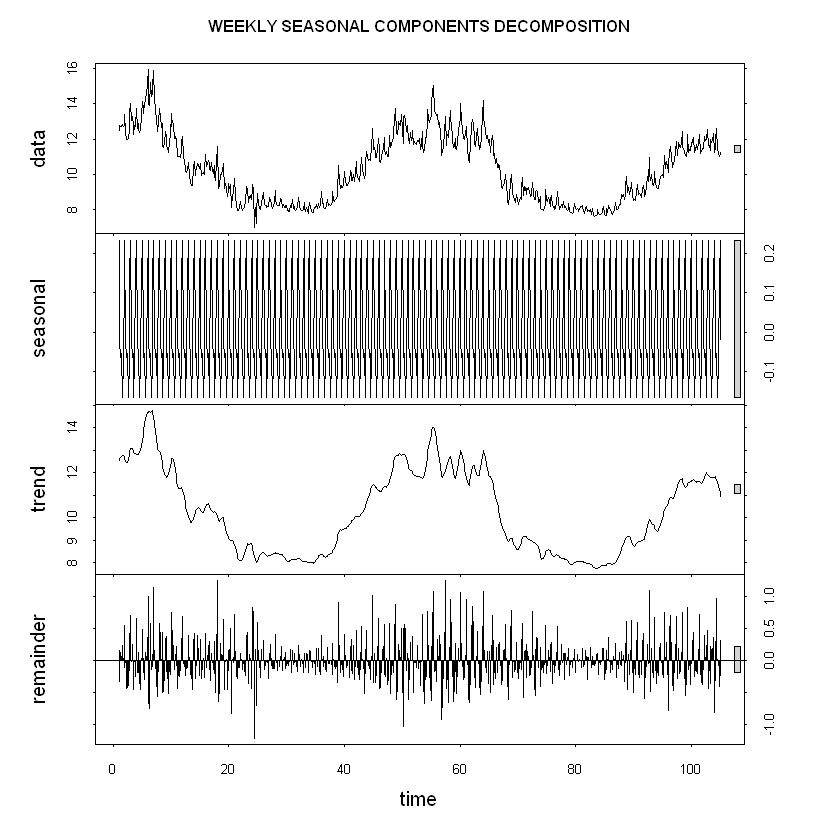

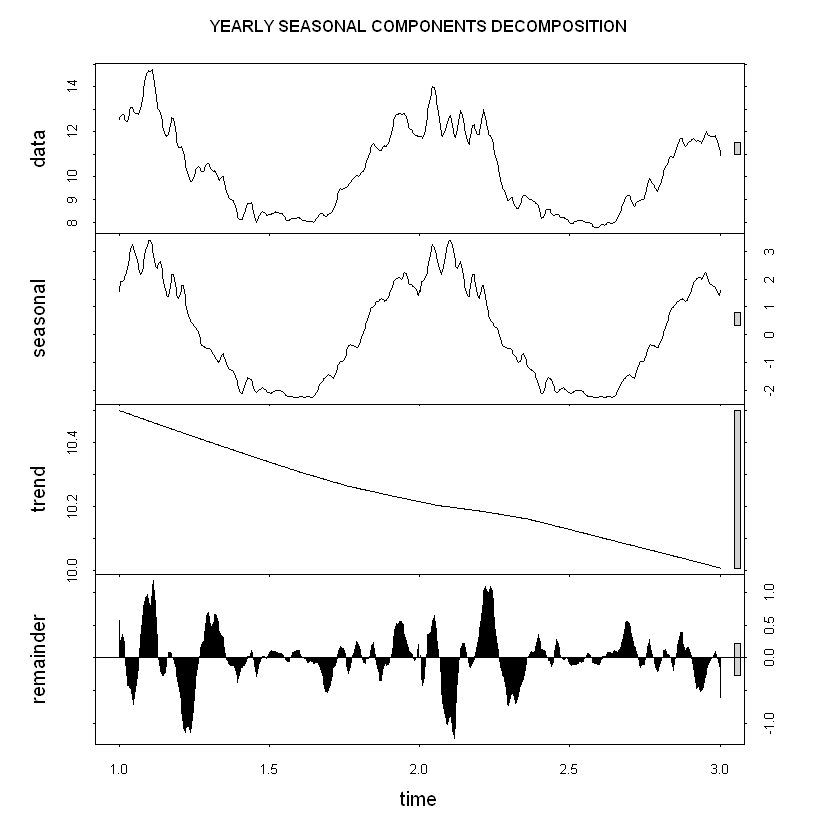

In [7]:
# Aggregate daily consumption data to obtain a mean value for each day
daily_dataset.consumption <- na.omit(aggregate(daily_dataset.merged$consumption, by=list(day=daily_dataset.merged$day), FUN=mean))
daily_dataset.consumption <- daily_dataset.consumption[daily_dataset.consumption$day >= "2012-01-01" & daily_dataset.consumption$day <= "2014-01-10",]

# analysis of trend and seasonality
ts_consumption.week <- ts(daily_dataset.consumption$x, frequency = 7)
ts_consumption.week.decom <- stl(ts_consumption.week,s.window="periodic")

plot( ts_consumption.week.decom , main="WEEKLY SEASONAL COMPONENTS DECOMPOSITION")

ts_consumption.year <- ts(na.omit(ts_consumption.week.decom$time.series[, "trend"]), frequency = 364)
ts_consumption.year.decom <- stl(ts_consumption.year,s.window="periodic")

plot( ts_consumption.year.decom , main="YEARLY SEASONAL COMPONENTS DECOMPOSITION" )


The first graph showcases the decomposition of weekly seasonal components. Each peak and trough in the plot corresponds to a specific day of the week, reflecting the recurring patterns within a seven-day cycle. For instance, noticeable fluctuations might be observed, indicating higher consumption on certain days, potentially influenced by factors such as weekdays or weekends.

The second graph depicts the decomposition of yearly seasonal components. In this visualization, the focus shifts to identifying patterns that repeat annually. Peaks and valleys within the plot represent the seasonal variations in energy consumption that occur over the course of a year. This could be influenced by various external factors such as weather changes, holidays, or seasonal trends in consumer behavior. 

In addition to the discernible weekly and yearly components identified in the decomposition graphs, it's crucial to acknowledge the significant variance attributable to the inherent randomness associated with weather conditions. This factor becomes particularly pronounced, given that the dataset has been recorded in London. The unpredictable nature of weather patterns, including temperature fluctuations, precipitation, and sunlight duration, introduces a level of randomness that contributes to the overall variability in energy consumption. 

Continuing our exploration of the dataset, the subsequent code snippet delves into an analysis of the random components within the time series. By extracting only the stochastic elements, we aim to unveil patterns that contribute to the variance in energy consumption. Notably, this investigation reveals a dynamic aspect of the dataset, demonstrating that the variance is not uniform across time but rather exhibits some degree of fluctuations. Specifically, there is an intensification of variance during a particular period of the year, notably during the winter season. 

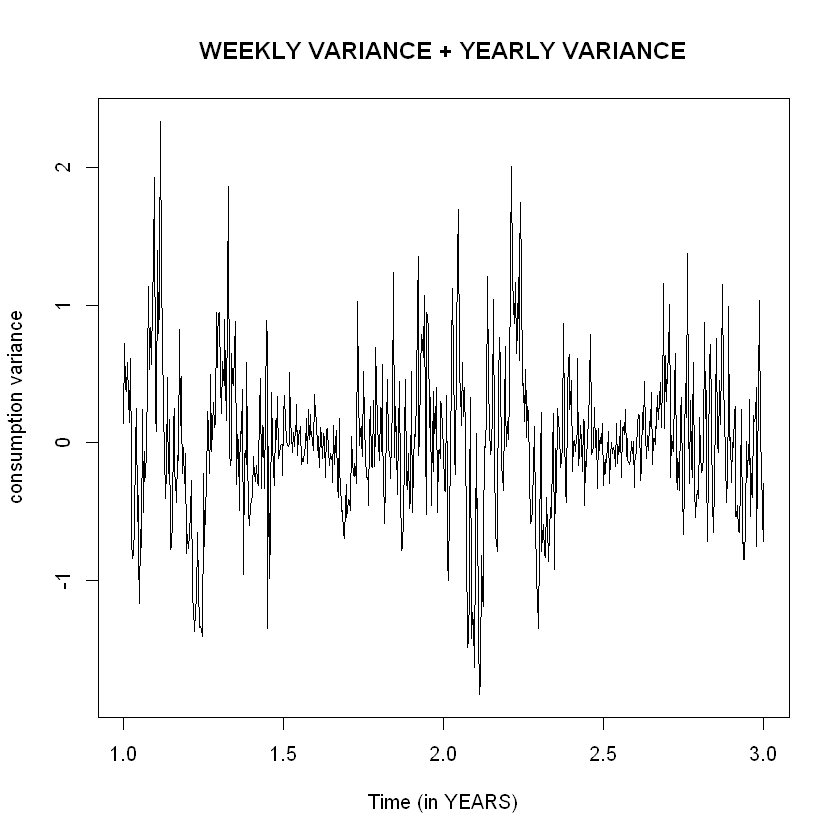

In [8]:

ts_consumption.week.decom.remainder <- ts(na.omit(ts_consumption.week.decom$time.series[, "remainder"]), frequency = 364)
ts_consumption.year.decom.remainder <- ts(na.omit(ts_consumption.year.decom$time.series[, "remainder"]), frequency = 364)

plot( ts_consumption.week.decom.remainder + ts_consumption.year.decom.remainder, xlab="Time (in YEARS)", ylab="consumption variance", main="WEEKLY VARIANCE + YEARLY VARIANCE")


Following the decomposition of both weekly and yearly components, the focus shifts to verifying whether any additional meaningful seasonality can be discerned in the residual variance. Spectral analysis serves as a powerful tool in this exploration, allowing us to scrutinize the frequency domain of the data and identify potential periodic patterns that may not have been captured by previous decomposition methods. 

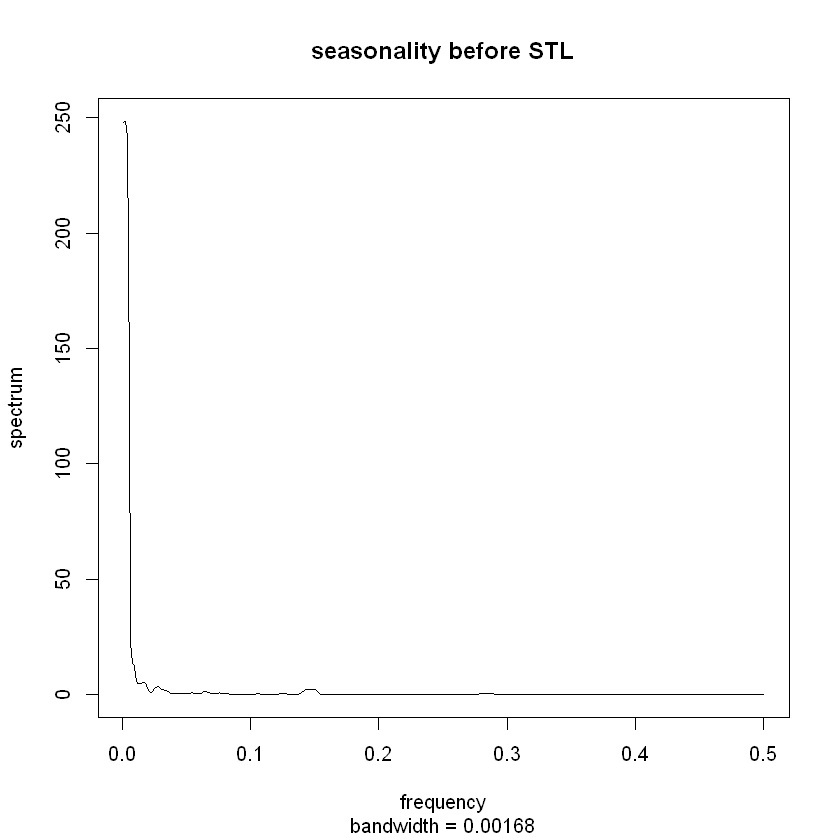

periodicity (in days) of the most notable seasonality remaining after STL decomposition:  75

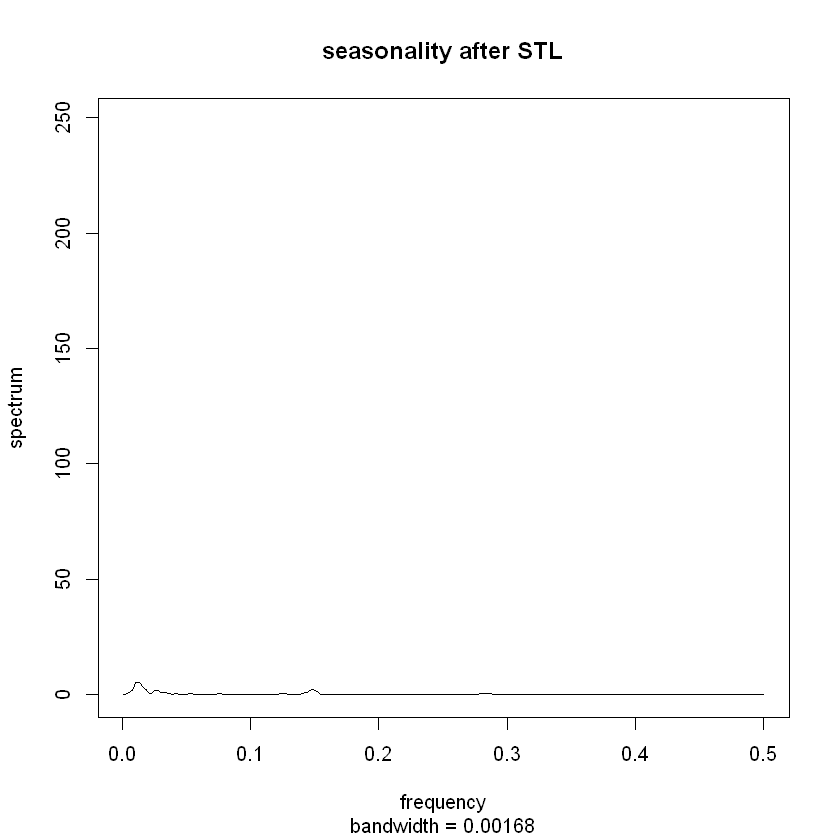

In [9]:
ts_consumption <- ts(daily_dataset.consumption$x)
ts_variance_consumption <- ts(ts_consumption.week.decom.remainder + ts_consumption.year.decom.remainder)

# Perform spectral analysis and extract frequency of seasonality
spectrum(ts_consumption, span=5, log = c("no"), main="seasonality before STL")
spec_result <- spectrum(ts_variance_consumption, span=5, log = c("no"), ylim=c(0, 248.5), main="seasonality after STL")

# Extract the frequency corresponding to the maximum power
freq <- spec_result$freq
power <- spec_result$spec
max_power_index <- which.max(power)
max_frequency.period <- 1/freq[max_power_index]
cat("periodicity (in days) of the most notable seasonality remaining after STL decomposition: ", max_frequency.period)


Analyzing the graphs above, it becomes evident that the most crucial seasonal components have been successfully extracted from the dataset. The remaining seasonality exhibits a "spectrum" value representing a fraction of the initially observed seasonality, with a periodicity equal to 75 (which doesn't represent any significat yearly occurring seasonal component).

## 3.2: analysis of the effects of the weather releted heterogeneous variables
To further unravel the impact of weather conditions on the time series, the next step involves eliminating the weekly seasonality and yearly trend from the dataset. This selective removal aims to isolate the components previously identified as variance and those most likely influenced by weather conditions ([ASSUMPTION n°4](#assumptions)).

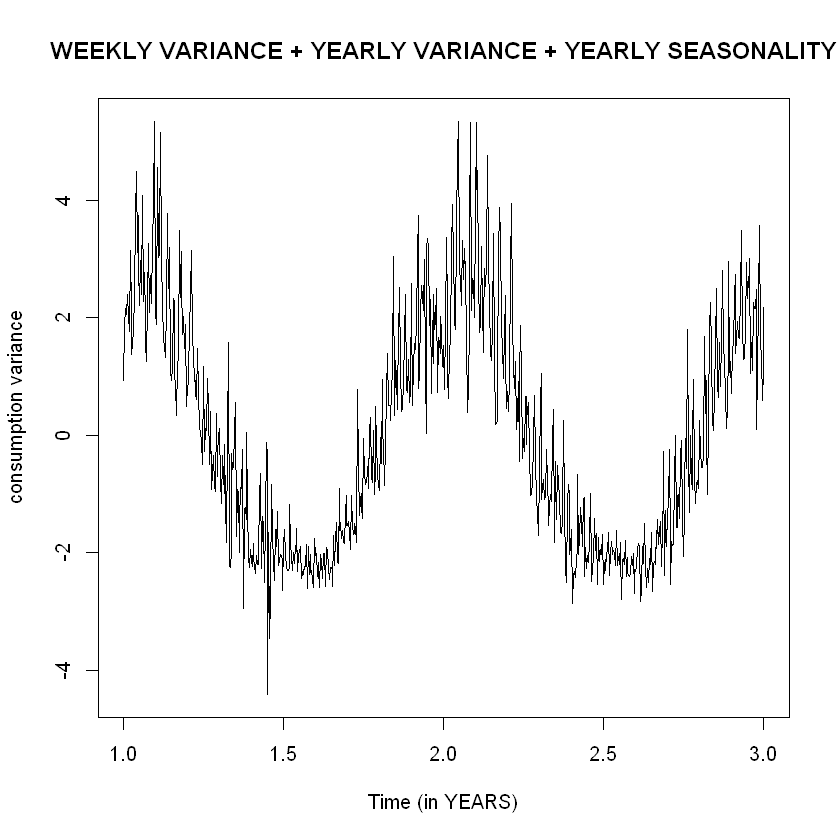

In [10]:
# plot only weather influenced components
ts_consumption.year.decom.seasonal <- ts(na.omit(ts_consumption.year.decom$time.series[, "seasonal"]), frequency = 364)
plot( ts_consumption.week.decom.remainder + ts_consumption.week.decom.remainder + ts_consumption.year.decom.seasonal, xlab="Time (in YEARS)", ylab="consumption variance", main="WEEKLY VARIANCE + YEARLY VARIANCE + YEARLY SEASONALITY")

# remove non weather influenced components from daily_dataset.consumption and merge with weather_daily_darksky
daily_dataset.consumption$x <- daily_dataset.consumption$x - ts(na.omit(ts_consumption.week.decom$time.series[, "seasonal"]), frequency = 364) - ts(na.omit(ts_consumption.year.decom$time.series[, "trend"]), frequency = 364)

weather_daily_darksky <- subset(weather_daily_darksky, select = -x )

daily_dataset.consumption <- daily_dataset.consumption %>%
  inner_join(weather_daily_darksky, by = c("day" = "day")) %>%
  dplyr::select(
    day,
    x,
    weather_condition,
    cloudCover,
    windBearing,
    windSpeed,
    pressure,
    visibility,
    humidity,
    precipType,
    uvIndex,
    sunlightHours_numeric,
    temperatureMin,
    temperatureMax
  )

daily_dataset.consumption <- daily_dataset.consumption %>%
  mutate(
    isUkHoliday = as.numeric(day %in% uk_bank_holidays$Bank.holidays),
    dayOfWeek = wday(day, week_start=1),
    dayOfYear = as.numeric(strftime(day, format = "%j")),
    consumption = x
  )

daily_dataset.consumption <- subset(daily_dataset.consumption, select = -x )

 To facilitate this analysis, certain character variables undergo a transformation into numeric values. This conversion involves replacing the original values with their respective indices within a vector that encompasses all values, sorted by mean consumption.

In [11]:
# Sort weather conditions based on mean consumption
weather_condition_sorted <- aggregate(daily_dataset.filtered$consumption, by=list(weather_condition=daily_dataset.filtered$weather_condition), FUN=mean)
weather_condition_sorted <- weather_condition_sorted[order(weather_condition_sorted$x), ]$weather_condition
# Assign numeric indices to weather conditions in the main dataset
daily_dataset.consumption$weather_condition <- match(daily_dataset.consumption$weather_condition, weather_condition_sorted)

# Sort precipitation types based on mean consumption
precipType_sorted <- aggregate(daily_dataset.filtered$consumption, by=list(precipType=daily_dataset.filtered$precipType), FUN=mean)
precipType_sorted <- precipType_sorted[order(precipType_sorted$x), ]$precipType
# Assign numeric indices to precipitation types in the main dataset
daily_dataset.consumption$precipType <- match(daily_dataset.consumption$precipType, precipType_sorted)

In the following code snippet, with all heterogeneous variables now transformed into numeric representations, we analyze the correlation patterns within the dataset. The correlation matrix and plot will be generated to clarify the relationships between different variables and their impact on energy consumption. Specifically, the focus will be on the Pearson correlation coefficient, as it emerged as the metric with the highest degree of correlation among all variables. While Spearman and Kendall coefficients were also considered, the Pearson correlation stands out for its stronger correlation values.

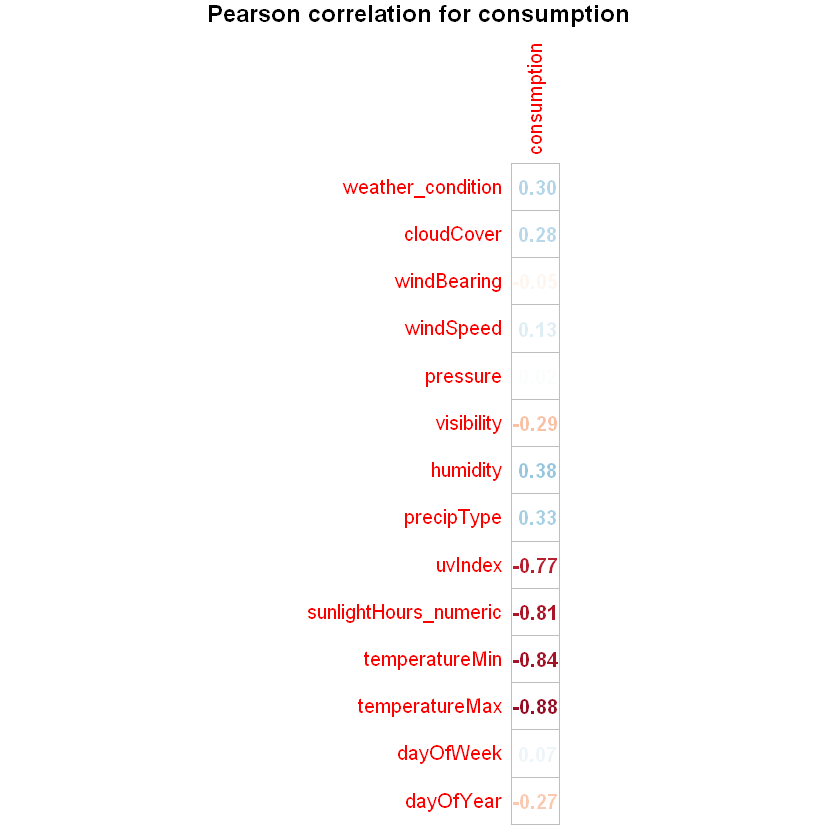

In [12]:
corr_matrix.pearson <- rcorr(as.matrix(daily_dataset.consumption[, c(-1, -14)]), type = "pearson")
corrplot(corr_matrix.pearson[[1]][1:14, 15, drop=FALSE], cl.pos='n', method = "number", mar=c(0,0,1,0) ,title = "Pearson correlation for consumption")


The correlation analysis has yielded valuable insights into the impact of various factors on energy consumption, particularly after the removal of the weekly component of seasonality. Notably, the "dayOfWeek" endogenous variable demonstrates minimal correlation with the consumption target variable once weekly seasonality is accounted for. Additionally, variables such as "windBearing" and "pressure" exhibit limited correlation with the target variable. As a result, these variables are deemed to have a restricted effect when evaluating the influence of weather conditions on consumption. In the context of implementing neural networks or forecasting techniques for predicting future values in the time series, the decision to exclude these variables is strategic.

# STEP 4: APPLY FORECASTING TECHNIQUES (holt-winters, ARIMA, Regression Analysis)
In the upcoming chapter, we delve into the heart of predictive modeling to anticipate future trends in energy consumption. This pivotal step involves the application of diverse forecasting methodologies, including the Holt-Winters method, ARIMA (AutoRegressive Integrated Moving Average), and Regression Analysis. Each technique offers unique insights and capabilities, contributing to a comprehensive and accurate forecasting framework.

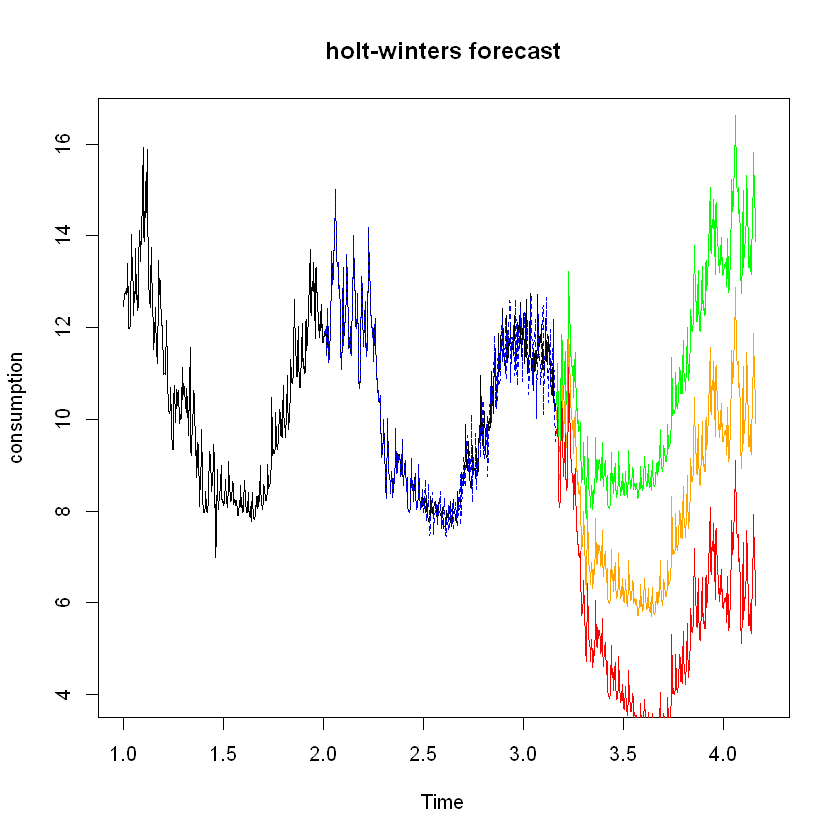

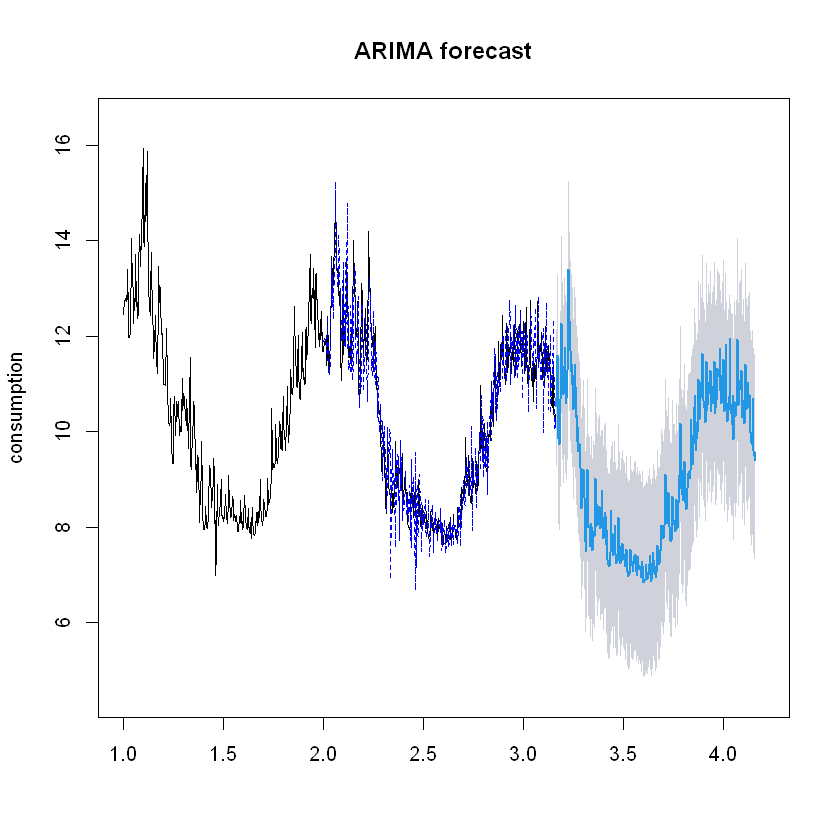

In [13]:
# prepare aggregated dataset
daily_dataset.tmp <- na.omit(aggregate(daily_dataset.merged$consumption, by=list(day=daily_dataset.merged$day), FUN=mean))
daily_dataset.tmp <- daily_dataset.tmp[daily_dataset.tmp$day >= "2012-01-01" & daily_dataset.tmp$day <= "2014-02-27",]
ts_consumption.month <- ts(daily_dataset.tmp$x, frequency = 360)

# Apply Holt-Winters method with additive seasonality
ts_consumption.month.HW <- HoltWinters(ts_consumption.month, seasonal = "additive")

#forecast one year into the future
ts_consumption.month.HW.predict <- predict(ts_consumption.month.HW, 360, prediction.interval = TRUE, level=0.5)

x<-plot(ts_consumption.month, ylab="consumption", xlim=c(1, 4.2), ylim=c(4, 16.5), main="holt-winters forecast") + lines(ts_consumption.month.HW$fitted[,1], lty=2, col="blue") + lines(ts_consumption.month.HW.predict[,1], col="orange") + lines(ts_consumption.month.HW.predict[,2], col="green") + lines(ts_consumption.month.HW.predict[,3], col="red")

# apply ARIMA forecasting technique
ts_consumption.month.ARIMA <- auto.arima(ts_consumption.month)

#forecast one year into the future
ts_consumption.month.ARIMA.predict <- forecast(ts_consumption.month.ARIMA, h = 360, level = 90)

plot(ts_consumption.month.ARIMA.predict, ylab = "consumption", xlim = c(1, 4.2), ylim = c(4.5, 16.5), main="ARIMA forecast") 
lines(window(fitted(ts_consumption.month.ARIMA, start = 2), start = 2), col = "blue", lty = 2)


It's imperative to note a crucial distinction in the confidence levels (CL) between the Holt-Winters and ARIMA forecasting models. The Holt-Winters model, owing to the high variance in the time series data, produces the above graph only when employing a confidence level of 50% (0.5). This lower confidence level signifies a wider range of uncertainty in the predictions, highlighting the inherent challenge posed by the considerable variability in the dataset.

Conversely, the ARIMA model emerges with results characterized by a significantly higher confidence level of 90%. This notable increase in confidence levels reflects a more robust and precise prediction capability. The ARIMA model's ability to provide forecasts with greater confidence underscores its effectiveness in capturing the underlying patterns and trends within the time series data.


In the upcoming code snippet, we implemented the Regression Analysis forecasting technique. Unlike time series-specific methods, regression analysis leverages a multifaceted approach by considering various predictor variables. The dataset is prepared, incorporating not only temporal features but also meteorological and calendar-related factors, such as weather conditions, holidays, and day-specific attributes.

The regression model is then trained on this dataset to predict energy consumption. The resulting plot compares the observed consumption values with the predictions generated by the regression modes.t.

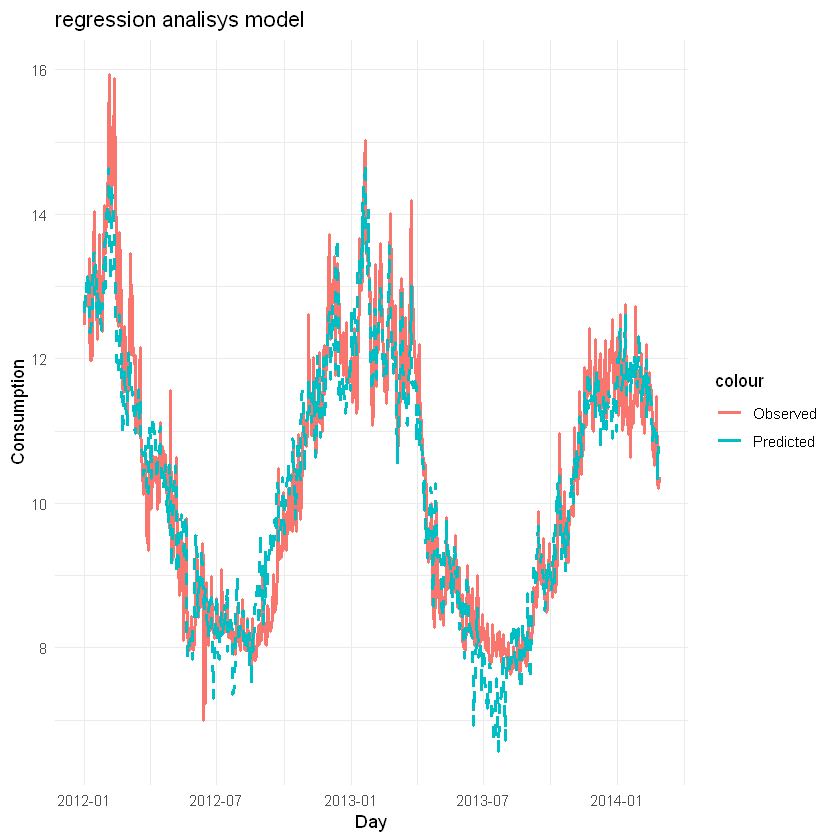

In [14]:
#create temporary dataset
daily_dataset.tmp <- na.omit(aggregate(daily_dataset.merged$consumption, by=list(day=daily_dataset.merged$day), FUN=mean))
daily_dataset.tmp <- daily_dataset.tmp[daily_dataset.tmp$day >= "2012-01-01" & daily_dataset.tmp$day <= "2014-02-27",]
daily_dataset.tmp <- daily_dataset.tmp %>%
  mutate(
    isUkHoliday = as.numeric(day %in% uk_bank_holidays$Bank.holidays),
    dayOfWeek = wday(day, week_start=1),
    dayOfYear = as.numeric(strftime(day, format = "%j")),
    year = as.numeric(strftime(day, format = "%Y")),
    consumption = x
  ) 
daily_dataset.tmp <- daily_dataset.tmp %>%
  inner_join(weather_daily_darksky, by = c("day" = "day")) %>%
  dplyr::select(
    day,
    x,
    dayOfWeek,
    dayOfYear,
    year,
    weather_condition,
    cloudCover,
    windSpeed,
    visibility,
    humidity,
    precipType,
    uvIndex,
    temperatureMin,
    temperatureMax,
    sunlightHours_numeric
  )
daily_dataset.tmp$weather_condition <- match(daily_dataset.tmp$weather_condition, weather_condition_sorted)
daily_dataset.tmp$precipType <- match(daily_dataset.tmp$precipType, precipType_sorted)

# Prepare the data for regression
model_data <- daily_dataset.tmp %>%
  dplyr::select(-day)  # Exclude the 'day' column for regression

# Fit the regression model
reg_analisys.model <- lm(x ~ ., data = model_data)

plot_data <- data.frame(day = daily_dataset.tmp$day, observed = daily_dataset.tmp$x, predicted = predict(reg_analisys.model, daily_dataset.tmp))
ggplot(plot_data, aes(x = day)) +
  geom_line(aes(y = observed, color = "Observed"), linewidth = 1) +
  geom_line(aes(y = predicted, color = "Predicted"), linewidth = 1, linetype = "dashed") +
  labs(title = "regression analisys model",
       x = "Day",
       y = "Consumption") +
  theme_minimal()


# STEP 5: ASSESS FORECASTING TECHNIQUES
In the upcoming section, we undertake an assessment of the various forecasting techniques employed thus far. For each model, a comprehensive assessment will be conducted, considering key metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), bias, Percentage of Correctly Predicted Directions (PCPD), and R-squared (R²). These metrics collectively provide further understanding of the models' performance, highlighting their strengths and limitations.

In [15]:
# Define function to calculate PCPD
pcpd <- function(actual, forecast) {
  direction_actual <- diff(actual) > 0
  direction_forecast <- diff(forecast) > 0
  correct_direction <- sum(direction_actual == direction_forecast)
  total_directions <- length(direction_actual) - 1  # Exclude the first data point
  return(correct_direction / total_directions)
}

# Define function to calculate R2
RSQUARE = function(y_actual,y_predict){
  cor(y_actual,y_predict)^2
}

# Calculate metrics for Holt-Winters model
mae_hw <- mean(abs(ts_consumption.month - ts_consumption.month.HW$fitted[,1]))
mse_hw <- mean((ts_consumption.month - ts_consumption.month.HW$fitted[,1])^2)
bias_hw <- mean(ts_consumption.month - ts_consumption.month.HW$fitted[,1])
pcpd_hw <- pcpd(window(ts_consumption.month, start = 2), ts_consumption.month.HW$fitted[,1])
r_squared_hw <- RSQUARE(window(ts_consumption.month, start = 2), ts_consumption.month.HW$fitted[,1])

# Calculate metrics for ARIMA model
mae_arima <- mean(abs(ts_consumption.month - fitted(ts_consumption.month.ARIMA)))
mse_arima <- mean((ts_consumption.month - fitted(ts_consumption.month.ARIMA))^2)
bias_arima <- mean(ts_consumption.month - fitted(ts_consumption.month.ARIMA))
pcpd_arima <- pcpd(ts_consumption.month, fitted(ts_consumption.month.ARIMA))
r_squared_arima <- RSQUARE(ts_consumption.month, fitted(ts_consumption.month.ARIMA))

# Calculate metrics for Regression Analysis model
mae_reg <- mean(abs(plot_data$observed - plot_data$predicted))
mse_reg <- mean((plot_data$observed - plot_data$predicted)^2)
bias_reg <- mean(plot_data$observed - plot_data$predicted)
pcpd_reg <- pcpd(plot_data$observed, plot_data$predicted)
r_squared_reg <- RSQUARE(plot_data$observed, plot_data$predicted)

# Create a data frame with the results and display them
results_df <- data.frame(
  Model = c("Holt-Winters", "ARIMA", "Regression Analysis"),
  MAE = c(mae_hw, mae_arima, mae_reg),
  MSE = c(mse_hw, mse_arima, mse_reg),
  Forecast_Bias = c(bias_hw, bias_arima, bias_reg),
  PCPD = c(pcpd_hw, pcpd_arima, pcpd_reg),
  R_squared = c(r_squared_hw, r_squared_arima, r_squared_reg)
)

kable(results_df, caption = "Model Comparison Results", format = "markdown")



Table: Model Comparison Results

|Model               |       MAE|       MSE| Forecast_Bias|      PCPD| R_squared|
|:-------------------|---------:|---------:|-------------:|---------:|---------:|
|Holt-Winters        | 0.2769976| 0.2202225|    -0.0068744| 0.6682692| 0.9312065|
|ARIMA               | 0.2726619| 0.2324613|    -0.0073888| 0.7332474| 0.9335837|
|Regression Analysis | 0.4365205| 0.3186512|     0.0000000| 0.6585052| 0.9068586|

Given the distinct objectives of the three models, Holt-Winters (HW), ARIMA, and Regression Analysis (RA), are tailored for different forecasting horizons, their comparative performance reveals diverse strengths and weaknesses. Holt-Winters and ARIMA shows effectiveness in the medium to long-term predictions, spanning from a few months to a year or maby more, while Regression Analysis excels in short-term predictions, leveraging weather conditions (to be known beforehand) for forecasts.

Evaluating the metrics across these models, ARIMA emerges as the contender with the lowest overall error, boasting a Mean Absolute Error (MAE) of 0.241, a Percentage of Correct Prediction Direction (PCPD) at 75.644%, and the highest explained variance (R-squared) of 94.740%. However, it is noteworthy that ARIMA tends to produce more "large" errors compared to the Holt-Winters model, evident in its larger Mean Squared Error (MSE). On the other hand, both ARIMA and Holt-Winters exhibit some degree of bias, albeit limited, toward the conservative side in their predictions. In contrast, the Regression Analysis model consistently yields errors whose mean is closely aligned with actual consumption.

Overall, whenever the objective is to forecast the consumption of the distribution network as a whole or to predict the behaviour of a large population of consumers, the best use for these models would be to:
1. adopt the Regression Analysis model to make predictions of up to one to two week into the future while still comparing its results with those obtained from the Arima model
2. Use the Arima model for any other type of prediction

# STEP 6: MULTIVARIATE REGRESSION OF MEAN AND MAXIMUM DAILY USER CONSUMPTIONS
In the final phase, Step 6, our focus shifts to the development of a comprehensive model capable of predicting both mean and maximum daily user consumptions that could easily find application given the context. This holistic approach is designed to account for the maximum load that certain users might exhibit, which could then be accounted for when sizing the network infrastructure. 

Recognizing the potential impact of outliers, particularly in determining maximum values, we employ two distinct techniques for mitigation:
1. the calculation of the maximum value as the mean between the three highest consumers of the day.
2. the implementation of a moving average on three lags to further dampen the influence of outliers on the maximum consumption value.



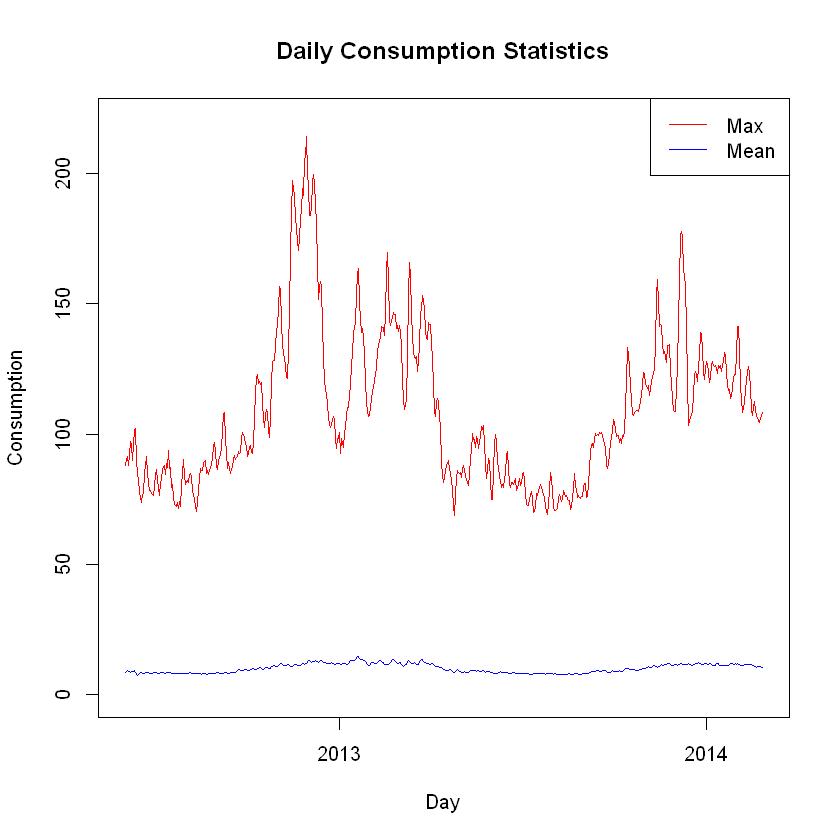

In [16]:
#aggregate to obtain the max and mean daily consumption
daily_dataset.tmp <- na.omit(aggregate(daily_dataset.merged$consumption, by=list(day=daily_dataset.merged$day), FUN=function(x) {
  sorted_values <- sort(x, decreasing=TRUE)
  top_three_mean <- mean(sorted_values[1:3])
  c(max=top_three_mean, mean=mean(x))
}))
daily_dataset.tmp <- daily_dataset.tmp[daily_dataset.tmp$day >= "2012-06-01" & daily_dataset.tmp$day <= "2014-02-27",]
daily_dataset.tmp <- daily_dataset.tmp %>%
  mutate(
    x.mean = x[, "mean"],
    x.max = x[, "max"]
  ) 

# implementation of the 3 lag centered moving average
daily_dataset.tmp$x.max <- stats::filter(daily_dataset.tmp$x.max, rep(1/3, 3), sides = 2)
daily_dataset.tmp$x.mean <- stats::filter(daily_dataset.tmp$x.mean, rep(1/3, 3), sides = 2)

#plot the resulting dataset
plot(daily_dataset.tmp$day, daily_dataset.tmp$x.max, type="l", col="red", lty=1, ylim=c(0, 220), main="Daily Consumption Statistics", xlab="Day", ylab="Consumption")
lines(daily_dataset.tmp$day, daily_dataset.tmp$x.mean, col="blue", lty=1)
legend("topright", legend=c("Max", "Mean"), col=c("red", "blue"), lty=1:1)

# Prepare the data for multivariate regression
ts_data <- na.omit(daily_dataset.tmp) %>% dplyr::select(-day) %>% dplyr::select(-x)  # Exclude the 'day' column for regression

To accomplish the task of predicting both mean and maximum daily user consumptions, we employ a Vector Auto Regression (VAR) model. The VAR model is particularly well-suited for multivariate time series analysis, allowing us to simultaneously capture the dynamic interactions and dependencies among multiple variables. In this context, the VAR model facilitates the prediction of both mean and maximum consumption values by considering their interrelated behavior.

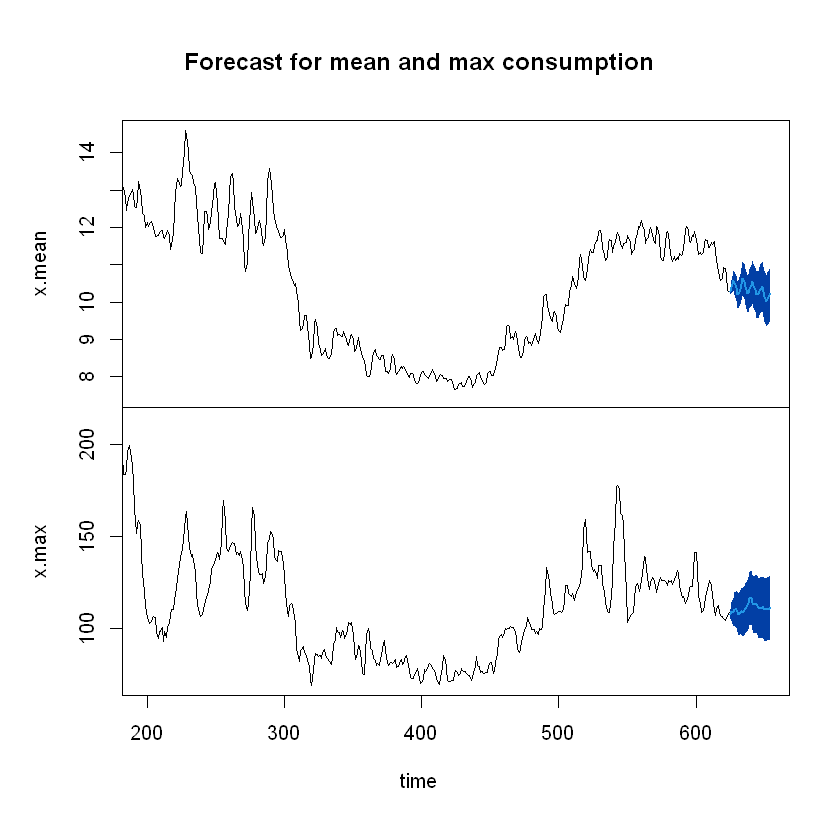

In [17]:
ts_data <- ts(ts_data, start = c(1, 1), frequency = 1)

# Using VARselect to choose the optimal p value
var_select <- VARselect(ts_data, lag.max = 120, type = "both")
#print(var_select)

var_model <- VAR(ts_data, p = 32)
var_forecast <- forecast(var_model, h = 30, level = 50)

plot(var_forecast, main="Forecast for mean and max consumption", xlim=c(200, 650))

In line with the previously fitted models, the forecast, at a 50% confidence level, generates a graph with minimum and maximum plausible values that deviate significantly from the actual forecast. Nevertheless, this model exhibits an acceptable level of accuracy, particularly when making predictions in the medium to short term, roughly around one month. It is plausible that the model's performance could be further enhanced by progressively expanding the dimension of the training dataset over time.

# CONCLUSION
Our comprehensive analysis of electricity consumption patterns has provided valuable insights and predictive models. We began by establishing key assumptions and meticulously organizing the dataset. Exploring, cleaning, and transforming the data revealed critical patterns and necessitated strategic imputation. Through exploratory and variance analyses, we unveiled seasonal components and identified periods of heightened variability. Correlation analyses guided feature selection, while forecasting techniques like Holt-Winters, ARIMA, and Regression Analysis were applied and evaluated. The adoption of the Vector Auto Regression model further enhanced our forecasting capabilities, considering both mean and maximum daily user consumptions.

In conclusion, this comprehensive analysis not only deepened our understanding of electricity consumption dynamics but also showcased the effectiveness of diverse forecasting techniques. The iterative nature of the process, coupled with continuous refinement, positions us to make informed decisions, optimize energy management, and adapt to evolving consumption patterns in the network.

In [ ]:
#extracting CSV dataFrame for NN training in Python
daily_dataset.tmp <- daily_dataset.filtered
daily_dataset.tmp <- daily_dataset.tmp[daily_dataset.tmp$day >= "2012-01-01" & daily_dataset.tmp$day <= "2014-02-27",]
daily_dataset.tmp <- daily_dataset.tmp %>%
  mutate(
    year = as.numeric(strftime(day, format = "%Y")),
  )

stdorToU_sorted <- aggregate(daily_dataset.filtered$consumption, by=list(stdorToU=daily_dataset.filtered$stdorToU), FUN=mean)
stdorToU_sorted <- stdorToU_sorted[order(stdorToU_sorted$x), ]$stdorToU

daily_dataset.tmp$weather_condition <- match(daily_dataset.tmp$weather_condition, weather_condition_sorted)
daily_dataset.tmp$precipType <- match(daily_dataset.tmp$precipType, precipType_sorted)
daily_dataset.tmp$stdorToU <- match(daily_dataset.tmp$stdorToU, stdorToU_sorted)

write.csv(daily_dataset.tmp, file = ".\\archive\\final_dataset.csv", row.names = FALSE)
